<a href="https://colab.research.google.com/github/nhuang37/dimensionality_reduction/blob/main/generative_vs_discriminative_SIMODS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment (Section 7.1): Generalization and robustness as a function of $n,p$

#### authors
- **David W Hogg** *(NYU) (MPIA) (Flatiron)*
- **Soledad Villar** *(JHU)* 
- **Ningyuan (Teresa) Huang** *(JHU)*

#### license
Copyright 2019, 2020, 2021 the authors. All rights reserved (for now).


### Data simulation

In [1]:
import numpy as np
import pylab as plt
from sklearn import linear_model as lm
%matplotlib inline

In [2]:
# set integers

# set data dimensionality
maximalD = 2 ** 9 # ESLII calls this "p"
fiducialD = 2 ** 7
M = 1 # ESLII always sets this to 1

# set training and test set sizes
fiducialN = 2 ** 6
maximalN = maximalD # maximum possible size of a training set
Ntest = 2 ** 8 # number of points to use to compute biases and variances
Ntrial = 2 ** 4 # number of training trials to use to compute biases and variances

In [3]:
# set God's X-Y covariance matrix (M+D x M+D)

# start with a random matrix
np.random.seed(13)
foo = np.random.normal(size=(M + maximalD, M + maximalD))
bar = foo @ foo.T

# and then manipulate eigenvalues
u, ss, v = np.linalg.svd(bar)
s = 1. * ss
sneakyKhack = 32
s[:sneakyKhack] = 1.e2 * s[:sneakyKhack] # MAGIC - HACK
maximalC = (u * s) @ v

In [4]:
def make_data_set(N, C, M):
  """
  actually make the random data, using the variance of God.

  Needs to be updated to take God's mean.
  """
  MplusD, foo = C.shape
  D = MplusD - M
  xys = np.random.multivariate_normal(np.zeros(MplusD), C, size=N)
  return xys[:, :D], xys[:, D:]

In [5]:
# make maximal train and test sets
np.random.seed(8675309 + 1)
maximalX = np.zeros((Ntrial, maximalN, maximalD))
maximalY = np.zeros((Ntrial, maximalN, M))
for trial in range(Ntrial):
  maximalX[trial], maximalY[trial] = make_data_set(maximalN, maximalC, M)
maximalXtest = np.zeros((Ntrial, Ntest, maximalD))
maximalYtest = np.zeros((Ntrial, Ntest, M))
for trial in range(Ntrial):
  maximalXtest[trial], maximalYtest[trial] = make_data_set(Ntest, maximalC, M)
print(maximalX.shape, maximalY.shape)

(16, 512, 512) (16, 512, 1)


1425911.6867595671 1425911.6867595674


Text(0.5, 1.0, 'SVD of the fiducial data set, zeroth trial')

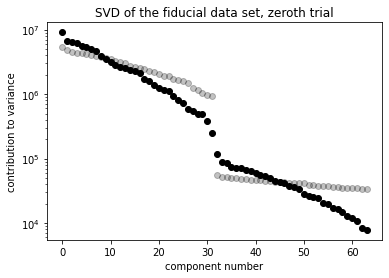

In [6]:
u, s, v = np.linalg.svd(maximalX[0, :fiducialN, -fiducialD:], full_matrices=False)
plt.plot(s ** 2, "ko")
C = maximalC[-fiducialD-M:, -fiducialD-M:]
uu, ss, vv = np.linalg.svd(C)
plt.plot((fiducialN * ss)[:fiducialN], "ko", alpha=0.24)
print(np.sum(ss), np.trace(C))
plt.semilogy()
#plt.ylabel("contribution to variance")
plt.ylabel("contribution to variance")
plt.xlabel("component number")
plt.title("SVD of the fiducial data set, zeroth trial")

### Methods
- OLS
- PCA-OLS and variants
- Ridge
- Lasso
- Generative models and variants

In [7]:
def gods_estimator(C, M):
  """
  WARNING: This function needs to know about God's mean mu, and
  be fixed to incorporate it.

  make the best possible estimator, in terms of mean squared error on y
  (this, we hope, is what everything approaches, in the limit N -> infinity)
  """
  MplusD, foo = C.shape
  D = MplusD - M
  Cxx = C[:D, :D]
  Cxy = C[:D, D:]
  return np.linalg.lstsq(Cxx, Cxy, rcond=None)[0].T

In [8]:
def train_null_model(xs, ys):
  N, D = xs.shape
  NN, M = ys.shape
  assert N == NN
  return np.zeros((M, D))

def train_discriminative_model(xs, ys, lamb=0):
  """
  train discriminative model y = B x + noise
  
  ## inputs:
  - xs - array of training data
  - ys - array of training labels

  ## comments
  Informally speaking, this finds the B that minimizes || ys - B . xs || (plus
  some regularization), and returns the discriminative matrix B.

  ## bugs:
  - Properly, this should take in an estimate of the inverse variances. These
    might be some processing of the xivars and yivars; we need to figure that
    out.
  - Doesn't fit for a bias term (that is, a zero-offset).
  """
  N, D = xs.shape
  NN, M = ys.shape
  assert N == NN
  if lamb == 0:
    return np.linalg.lstsq(xs, ys, rcond=None)[0].T
  return np.linalg.lstsq(xs.T @ xs + N * lamb * np.eye(D), xs.T @ ys, rcond=None)[0].T

def pca_projector(xs, K):
  u, s, v = np.linalg.svd(xs, full_matrices=False)
  v = v[:K, :]
  return v.T @ v

def train_lasso_model(xs, ys, lamb):
  llm = lm.Lasso(alpha=lamb)
  llm.fit(xs, ys)
  return np.atleast_2d(llm.coef_)

def train_augmented_ols_model(xs, ys, lamb, Ntrial=1):
  """
  This is stupid; don't ask.

  BUG: Hard-coded to add N+D features.
  """
  N, D = xs.shape
  NN, M = ys.shape
  assert N == NN
  Bs = np.zeros((Ntrial, M, D)) + np.nan
  for k in range(Ntrial):
    augmented_xs = np.hstack((xs, (lamb / N) * np.random.normal(size=(N, (D + N)))))
    Bs[k] = train_discriminative_model(augmented_xs, ys)[:, :D]
  return np.mean(Bs, axis=0)

def train_pca_discriminative_model(xs, ys, K):
  """
  Same as discriminative, but first reducing the x-y data to a rank-K
  approximation by PCA.

  BUG: Implementation is SLOW (makes too many PCA components).

  BUG: Doesn't deal with non-zero mean.
  """
  N, D = xs.shape
  NN, M = ys.shape
  assert N == NN
  foo = np.hstack((xs, ys))
  u, s, v = np.linalg.svd(foo, full_matrices=False)
  bar = min(min(K, N), (D + M)) # is this correct? MSV's fault if not
  s, v = s[:bar], v[:bar]
  return gods_estimator(v.T * s ** 2 @ v, M)

def train_pca_generative_model(X, Y, K):
  """
  DOESN'T DEAL WITH MEAN X CORRECTLY.
  """
  u, s, v = np.linalg.svd(X, full_matrices=False)
  B = train_discriminative_model((u * s)[:, :K], Y)
  return B @ v[:K, :]

def train_trivial_generative_model(xs, ys):
  """
  ## bugs:
  - Doesn't fit for a bias term (that is, a zero-offset).
  """
  return np.linalg.lstsq(ys, xs, rcond=None)[0]

def initialize_a_generative_model(Y, P, rcond=1e-5):
  Z = np.linalg.lstsq(P, Y.T, rcond=rcond)[0]
  proj_P = P.T @ np.linalg.lstsq(P @ P.T, P, rcond=rcond)[0]
  M, K = P.shape
  proj_Pperp = np.identity(K) - proj_P
  return proj_P @ Z, proj_Pperp @ np.random.normal(size=Z.shape), proj_Pperp

def train_msv_generative_model(X, Y, P, maxiter=10000, Z=None, rcond=1e-6, lamb=1.0):
  """
  ## Inputs:
  X: N x D
  Y: N x M
  P: M x K

  ## Comments:
  among all solutions Z such that Y=Z*P.T (ie Y.T=P*Z.T)
  we minimize ||X - Z*A|| by alternating minimization
  we write Z = Z0 + Z1, proj_P*Z=Z0, proj_Pperp*Z = Z1 

  ## bugs:
  - Doesn't use xivars, yivars.
  - Doesn't fit for a bias term (that is, a zero-offset).
  - ***K should be less than D(P): set rcond to around 1e-6 to avoid numeric issue
  """

  M, K = P.shape
  
  Z0, Z1, proj_Pperp = initialize_a_generative_model(Y, P)
  if Z is None:
    Z = Z0 + Z1
    #print(Z0.shape, Z1.shape, Z.shape)
  tiny = 1.e-9
  unconverged = True
  last_cost=np.inf
  for i in range(maxiter):
    # normalize the perpendicular part of Z
    Z1 = proj_Pperp @ Z
    Z -= Z1
    Z1 /= tiny + np.sqrt(np.mean(Z1 ** 2, axis=1))[:, None]
    Z += Z1

    #fix Z optimize for A
    #print(Z.T.shape, X.shape)
    A=np.linalg.lstsq(Z @ Z.T + lamb * (Z1 @ Z1.T) ,  Z @ X, rcond=rcond)[0]
    #A=np.linalg.lstsq(Z.T, X, rcond=rcond)[0] #larger rcond for better condition number
    #print(A.shape, Z.shape)

    #fix A optimize for Z
    a = A.T @ proj_Pperp.T
    b = X.T - A.T @ Z0
    Z1 = np.linalg.lstsq(a, b, rcond=rcond)[0]
    Z1 = proj_Pperp @ Z1

    #convergence
    Z_old = Z
    Z = Z0 + Z1
    #BUG: unstable! 
    #print('convergence, cost')
    cost= np.linalg.norm(X.T - A.T @ Z)
    #print(cost)

    if cost >= last_cost:
      unconverged = False
      break
    last_cost = cost
  if unconverged: print("train_msv_generative_model(): WARNING: did not converge.")
  return  P @ np.linalg.lstsq(A @ A.T, A, rcond=rcond)[0], Z.T, A 

In [11]:
# run on the first trial case, for the fiducials
### check msv generative peak at D=K=32
xs_train = maximalX[0, :fiducialN, -fiducialD:]
ys_train = maximalY[0, :fiducialN, :]
xs_test = maximalXtest[0, :, -fiducialD:]
ys_test = maximalYtest[0, :, :]
C = maximalC[-fiducialD-M:, -fiducialD-M:]
W = gods_estimator(C, M)

K = 64 # stupid #try K=P=128, K=P=32
assert K >= M

#print(xs_train.shape, ys_train.shape)
B_null = train_null_model(xs_train, ys_train)
B = train_discriminative_model(xs_train, ys_train)
B_pca = train_pca_discriminative_model(xs_train, ys_train, K)
Hdagger = train_trivial_generative_model(xs_train, ys_train)
#print(B.shape, Hdagger.shape)

P = np.random.normal(size=(K,1)).T #np.eye(K)[:M, :]# 
#print(P.shape)
G_msv, zs, qs = train_msv_generative_model(xs_train, ys_train, P,rcond=1e-6)
G_pca = train_pca_generative_model(xs_train, ys_train, K)
#G_wow, zs = train_wow_generative_model(xs_train, ys_train, P, 1000., Z = zs)
# hack: Use MSV's latents to initialize DWH's model
# G_dwh, zs = train_dwh_generative_model(xs_train, ys_train, P, Cx, Cy, Z=zs)

ys_efficient_test = (W @ xs_test.T).T #W is information theory optimal
ys_msv_test = (G_msv @ xs_test.T).T
ys_pca_test = (G_pca @ xs_test.T).T
#ys_wow_test = (G_wow @ xs_test.T).T
ys_discriminative_test = (B @ xs_test.T).T
ys_null_test = (B_null @ xs_test.T).T
ys_pca_discriminative_test = (B_pca @ xs_test.T).T

In [12]:
def rms(x):
  return np.mean(x * x)
  #return np.sqrt(np.mean(x * x))

m = 0
print("best possible", rms(ys_test[:, m] - ys_efficient_test[:, m]))
print("OLS", rms(ys_test[:, m] - ys_discriminative_test[:, m]))
print("null", rms(ys_test[:, m] - ys_null_test[:, m]))
print("joint-PCA-OLS", rms(ys_test[:, m] - ys_pca_discriminative_test[:, m]))
print("generative", rms(ys_test[:, m] - ys_msv_test[:, m]))
print("PCA-OLS", rms(ys_test[:, m] - ys_pca_test[:, m]))

best possible 510.9296903306025
OLS 1443.939031442821
null 10633.62135385226
joint-PCA-OLS 1443.9390314428201
generative 1443.93903144262
PCA-OLS 1443.9390314428163


In [13]:
# make K plot at fiducialN, fiducialD
D = fiducialD
N = fiducialN
Ks = np.unique(np.round(2. ** np.arange(0., np.log2(D) + 0.76, 0.25)).astype(int))
dys_K = np.zeros((len(Ks), 6, Ntrial, Ntest, M)) + np.nan
for ii, K in enumerate(Ks):
  print("starting trials for K =", K)
  P = np.eye(K)[:M, :]
  C = maximalC[-D-M:, -D-M:]
  W = gods_estimator(C, M)
  Bs, Gs_msv, Gs_pca = [], [], []
  for trial in range(Ntrial):
    xs_train = maximalX[trial, :N, -D:]
    ys_train = maximalY[trial, :N, :]
    xs_test = maximalXtest[trial, :, -D:]
    ys_test = maximalYtest[trial, :, :]
    B = train_discriminative_model(xs_train, ys_train)
    PK = pca_projector(xs_train, K)
    B_proj = (PK @ B.T).T
    B_pca = train_pca_discriminative_model(xs_train, ys_train, K)
    Bs.append(B)
    G_msv, zs, qs = train_msv_generative_model(xs_train, ys_train, P)
    Gs_msv.append(G_msv)
    G_pca = train_pca_generative_model(xs_train, ys_train, K)
    Gs_pca.append(G_pca) #BUG: was G_msv; should be G_pca
    dys_K[ii, 0, trial] = ys_test - (B @ xs_test.T).T
    dys_K[ii, 1, trial] = ys_test - (G_msv @ xs_test.T).T
    dys_K[ii, 2, trial] = ys_test - (G_pca @ xs_test.T).T
    dys_K[ii, 3, trial] = ys_test - (W @ xs_test.T).T
    dys_K[ii, 4, trial] = ys_test - (B_pca @ xs_test.T).T
    dys_K[ii, 5, trial] = ys_test - (B_proj @ xs_test.T).T

starting trials for K = 1
starting trials for K = 2
starting trials for K = 3
starting trials for K = 4
starting trials for K = 5
starting trials for K = 6
starting trials for K = 7
starting trials for K = 8
starting trials for K = 10
starting trials for K = 11
starting trials for K = 13
starting trials for K = 16
starting trials for K = 19
starting trials for K = 23
starting trials for K = 27
starting trials for K = 32
starting trials for K = 38
starting trials for K = 45
starting trials for K = 54
starting trials for K = 64
starting trials for K = 76
starting trials for K = 91
starting trials for K = 108
starting trials for K = 128
starting trials for K = 152
starting trials for K = 181
starting trials for K = 215


Text(0.5, 1.0, 'varying K at fixed D, N, C')

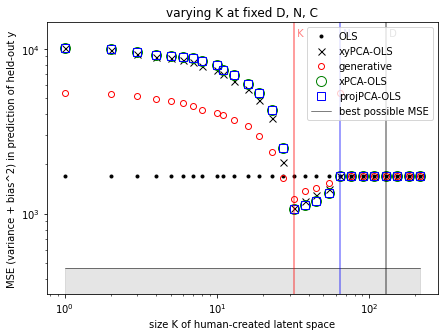

In [14]:
mses_K = np.mean(np.mean(np.mean(dys_K ** 2, axis=-1), axis=-1), axis=-1)
bestK = Ks[np.argmin(np.nanmin(mses_K[:, 1:3], axis=-1))]
K = bestK
plt.figure(figsize=(7, 5))
plt.subplot(111)
y1 = 0.7 * np.nanmin(mses_K)
y2 = np.nanmax(mses_K) / 0.7
yt = np.exp(np.log(y1) + 0.95 * np.log(y2 / y1))
plt.fill_between(Ks, mses_K[:, 3], y1 + 0. * mses_K[:, 3], color="k", alpha=0.1)
plt.plot(Ks, mses_K[:, 0], "k.", label="OLS")
plt.plot(Ks, mses_K[:, 4], "kx", ms=7, label="xyPCA-OLS")
plt.plot(Ks, mses_K[:, 1], "ro", mfc="none", label="generative")
plt.plot(Ks, mses_K[:, 2], "go", mfc="none", ms=10, label="xPCA-OLS")
plt.plot(Ks, mses_K[:, 5], "bs", mfc="none", ms=8, label="projPCA-OLS")
plt.plot(Ks, mses_K[:, 3], "k-", lw=0.5, label="best possible MSE")
plt.loglog()
plt.axvline(fiducialD, color="k", alpha=0.5)
plt.text(fiducialD, yt, " D", color="k", alpha=0.5)
plt.axvline(fiducialN, color="b", alpha=0.5)
plt.text(fiducialN, yt, " N", color="b", alpha=0.5)
plt.axvline(K, color="r", alpha=0.5)
plt.text(K, yt, " K", color="r", alpha=0.5)
plt.legend()
plt.ylim(y1, y2)
plt.ylabel("MSE (variance + bias^2) in prediction of held-out y")
plt.xlabel("size K of human-created latent space")
plt.title("varying K at fixed D, N, C")

In [15]:
import warnings
warnings.filterwarnings('ignore')
# make lambda plot at fiducialN, fiducialD
D = fiducialD
N = fiducialN
lambdas = np.exp(np.arange(np.log(1.e0), np.log(1.e6), np.log(2.)))
dys_lambda = np.zeros((len(lambdas), 5, Ntrial, Ntest, M)) + np.nan
for ii, lamb in enumerate(lambdas):
  print("starting trials for lambda =", np.round(lamb))
  P = np.eye(K)[:M, :]
  C = maximalC[-D-M:, -D-M:]
  W = gods_estimator(C, M)
  for trial in range(Ntrial):
    xs_train = maximalX[trial, :N, -D:]
    ys_train = maximalY[trial, :N, :]
    xs_test = maximalXtest[trial, :, -D:]
    ys_test = maximalYtest[trial, :, :]
    B = train_discriminative_model(xs_train, ys_train)
    Blam = train_discriminative_model(xs_train, ys_train, lamb=lamb)
    Baug = train_augmented_ols_model(xs_train, ys_train, lamb, Ntrial=16)
    Blas = train_lasso_model(xs_train, ys_train, lamb)
    dys_lambda[ii, 0, trial] = ys_test - (B @ xs_test.T).T
    dys_lambda[ii, 1, trial] = ys_test - (Blam @ xs_test.T).T
    dys_lambda[ii, 2, trial] = ys_test - (Baug @ xs_test.T).T
    dys_lambda[ii, 3, trial] = ys_test - (W @ xs_test.T).T
    dys_lambda[ii, 4, trial] = ys_test - (Blas @ xs_test.T).T

starting trials for lambda = 1.0
starting trials for lambda = 2.0
starting trials for lambda = 4.0
starting trials for lambda = 8.0
starting trials for lambda = 16.0
starting trials for lambda = 32.0
starting trials for lambda = 64.0
starting trials for lambda = 128.0
starting trials for lambda = 256.0
starting trials for lambda = 512.0
starting trials for lambda = 1024.0
starting trials for lambda = 2048.0
starting trials for lambda = 4096.0
starting trials for lambda = 8192.0
starting trials for lambda = 16384.0
starting trials for lambda = 32768.0
starting trials for lambda = 65536.0
starting trials for lambda = 131072.0
starting trials for lambda = 262144.0
starting trials for lambda = 524288.0


Text(0.5, 1.0, 'varying lambda at fixed D, N, C')

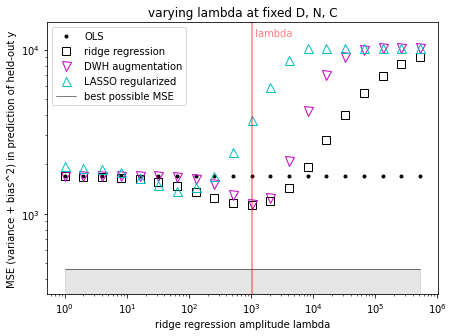

In [16]:
mses_lambda = np.nanmean(np.nanmean(np.nanmean(dys_lambda ** 2, axis=-1), axis=-1), axis=-1)
bestlambda = lambdas[np.argmin(np.nanmin(mses_lambda[:, 1:3], axis=-1))]
lamb = bestlambda
plt.figure(figsize=(7, 5))
plt.subplot(111)
y1 = 0.7 * np.nanmin(mses_lambda)
y2 = np.nanmax(mses_lambda) / 0.7
yt = np.exp(np.log(y1) + 0.95 * np.log(y2 / y1))
plt.fill_between(lambdas, mses_lambda[:, 3], y1 + 0. * mses_lambda[:, 3], color="k", alpha=0.1)
plt.plot(lambdas, mses_lambda[:, 0], "k.", label="OLS")
plt.plot(lambdas, mses_lambda[:, 1], "ks", mfc="none", ms=8, label="ridge regression")
plt.plot(lambdas, mses_lambda[:, 2], "mv", mfc="none", ms=9, label="DWH augmentation")
plt.plot(lambdas, mses_lambda[:, 4], "c^", mfc="none", ms=9, label="LASSO regularized")
plt.plot(lambdas, mses_lambda[:, 3], "k-", lw=0.5, label="best possible MSE")
plt.loglog()
plt.axvline(lamb, color="r", alpha=0.5)
plt.text(lamb, yt, " lambda", color="r", alpha=0.5)
plt.legend()
plt.ylim(y1, y2)
plt.ylabel("MSE (variance + bias^2) in prediction of held-out y")
plt.xlabel("ridge regression amplitude lambda")
plt.title("varying lambda at fixed D, N, C")

In [17]:
# make N plot at fiducialD
lamb = bestlambda
K = bestK
D = fiducialD
Ns = np.unique(np.round(2 ** np.arange(0., np.log2(maximalN) + 0.01, 0.25)).astype(int))
dys_N = np.zeros((len(Ns), 8, Ntrial, Ntest, M)) + np.nan
for ii, N in enumerate(Ns):
  print("starting trials for N =", N)
  C = maximalC[-D-M:, -D-M:]
  W = gods_estimator(C, M)
  P = np.eye(K)[:M, :] ##move up to be consistent of finding bestK
  for trial in range(Ntrial):
    xs_train = maximalX[trial, :N, -D:]
    ys_train = maximalY[trial, :N, :]
    xs_test = maximalXtest[trial, :, -D:]
    ys_test = maximalYtest[trial, :, :]
    B = train_discriminative_model(xs_train, ys_train)
    B_null = train_null_model(xs_train, ys_train)
    B_opt = train_discriminative_model(xs_train, ys_train, lamb=lamb)
    B_pca = train_pca_discriminative_model(xs_train, ys_train, K)
    P = np.eye(K)[:M, :]
    G_msv, zs, qs = train_msv_generative_model(xs_train, ys_train, P, lamb=0.5)
    G_pca = train_pca_generative_model(xs_train, ys_train, K)
    dys_N[ii, 0, trial] = ys_test - (B @ xs_test.T).T
    dys_N[ii, 1, trial] = ys_test - (G_msv @ xs_test.T).T
    dys_N[ii, 2, trial] = ys_test - (G_pca @ xs_test.T).T
    dys_N[ii, 3, trial] = ys_test - (W @ xs_test.T).T
    dys_N[ii, 4, trial] = ys_test - (B_pca @ xs_test.T).T
    dys_N[ii, 5, trial] = ys_test - (B_opt @ xs_test.T).T
    dys_N[ii, 6, trial] = ys_test - (B_null @ xs_test.T).T

starting trials for N = 1
starting trials for N = 2
starting trials for N = 3
starting trials for N = 4
starting trials for N = 5
starting trials for N = 6
starting trials for N = 7
starting trials for N = 8
starting trials for N = 10
starting trials for N = 11
starting trials for N = 13
starting trials for N = 16
starting trials for N = 19
starting trials for N = 23
starting trials for N = 27
starting trials for N = 32
starting trials for N = 38
starting trials for N = 45
starting trials for N = 54
starting trials for N = 64
starting trials for N = 76
starting trials for N = 91
starting trials for N = 108
starting trials for N = 128
starting trials for N = 152
starting trials for N = 181
starting trials for N = 215
starting trials for N = 256
starting trials for N = 304
starting trials for N = 362
starting trials for N = 431
starting trials for N = 512


### Plots for paper

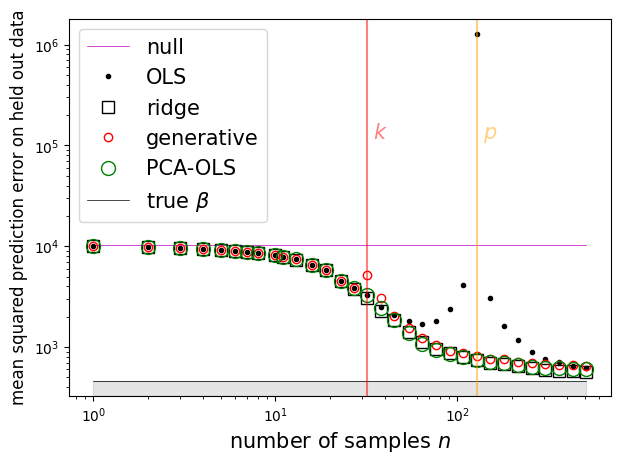

In [18]:
mses_N = np.mean(np.mean(np.mean(dys_N ** 2, axis=-1), axis=-1), axis=-1)
plt.figure(figsize=(7, 5), dpi=100)
plt.subplot(111)
y1 = 0.7 * np.nanmin(mses_N)
y2 = np.nanmax(mses_N) / 0.7
yt = np.exp(np.log(y1) + 0.95 * np.log(y2 / y1))
plt.fill_between(Ns, mses_N[:, 3], y1 + 0. * mses_N[:, 3], color="k", alpha=0.1)
plt.plot(Ns, mses_N[:, 6], "m-", lw=0.5, label="null")
plt.plot(Ns, mses_N[:, 0], "k.", label="OLS")
plt.plot(Ns, mses_N[:, 5], "ks", mfc="none", ms=8, label="ridge")
plt.plot(Ns, mses_N[:, 1], "ro", mfc="none", label="generative")
plt.plot(Ns, mses_N[:, 2], "go", mfc="none", ms=10, label="PCA-OLS")
plt.plot(Ns, mses_N[:, 3], "k-", lw=0.5, label=r"true $\beta$")
plt.loglog()
#cosmetic

plt.loglog()
plt.axvline(fiducialD, color="orange", alpha=0.5)
plt.text(fiducialD, yt/10, r" $p$", color="orange", alpha=0.5,size=15)
plt.axvline(K, color="r", alpha=0.5)
plt.text(K, yt/10, r" $k$", color="r", alpha=0.5,size=15)
plt.legend(loc="upper left",fontsize=15)
plt.ylim(y1, y2)
plt.ylabel(r"mean squared prediction error on held out data", size=12)
plt.xlabel(r"number of samples $n$",size=15)
#plt.title("varying D at fixed K, N; truncating or extending C")


plt.savefig("riskn.png")
plt.show()

In [19]:
# add adversary point
def attacker(X, Y, rand_vec, eps):
    x0 = rand_vec @ X + eps  #X[0,:] + eps  #X[0,:] + eps  #
    x0 = x0/np.linalg.norm(x0) 
    y0 = np.zeros((1,1))
    tildeX = np.concatenate((X, x0.reshape(1,-1)),axis=0)
    tildeY = np.concatenate((Y, y0),axis=0)
    return tildeX, tildeY

In [20]:
# make D plot at fiducialN
lamb = bestlambda
K = bestK
N = fiducialN
Ds = np.unique(np.round(2 ** np.arange(0., np.log2(maximalD) + 0.01, 0.25)).astype(int))
dys_D = np.zeros((len(Ds), 7, Ntrial, Ntest, M)) + np.nan
att_dys_D = np.zeros((len(Ds), 7, Ntrial, Ntest, M)) + np.nan #for attack results
trueconds_D = np.zeros(len(Ds)) + np.nan #god's condition numbers
conds_D_ols = np.zeros((Ntrial, len(Ds))) + np.nan #data condition numbers: OLS
conds_D_gen_Z = np.zeros((Ntrial, len(Ds))) + np.nan #data condition numbers: gen
conds_D_gen_Q = np.zeros((Ntrial, len(Ds))) + np.nan #data condition numbers: gen
Ws, Bs, Gs_msv, Gs_pca = [], [], [], []
Ps = np.random.normal(size=(D,1))
for ii, D in enumerate(Ds):
  print("starting trials for D =", D)
  C = maximalC[-D-M:, -D-M:] #god's condition number
  trueconds_D[ii] = np.linalg.cond(C)
  W = gods_estimator(C, M)
  Ws.append(W)
  for trial in range(Ntrial):
    xs_train = maximalX[trial, :N, -D:]
    ys_train = maximalY[trial, :N, :]
    xs_test = maximalXtest[trial, :, -D:]
    ys_test = maximalYtest[trial, :, :]
    #sample cond number: OLS
    if N < D:
      XX = xs_train @ xs_train.T
    else:
      XX = xs_train.T @ xs_train
    conds_D_ols[trial, ii] = np.linalg.cond(XX)

    #beta fitting
    B = train_discriminative_model(xs_train, ys_train)
    B_null = train_null_model(xs_train, ys_train)
    B_pca = train_pca_discriminative_model(xs_train, ys_train, K)
    B_opt = train_discriminative_model(xs_train, ys_train, lamb=lamb)
    # B_aug = train_augmented_ols_model(xs_train, ys_train, lamb, Ntrial=16)
    if trial == 0:
      Bs.append(B)
    P = Ps[:K,:].T ##NEW
    G_msv, zs, qs = train_msv_generative_model(xs_train, ys_train, P,rcond=2*1e-6)
    #sample cond number: gen -HUGE?? BUG???
    if N < K:
      ZZ = zs @ zs.T
      QQ = qs.T @ qs #np.linalg.cond(qs @ qs.T), np.linalg.cond(zs.T @ zs)
    else:
      ZZ = zs.T @ zs
      QQ = qs @ qs.T
    conds_D_gen_Z[trial, ii] = np.linalg.cond(ZZ)
    conds_D_gen_Q[trial,ii] = np.linalg.cond(QQ)
    if trial == 0:
      Gs_msv.append(G_msv)
    G_pca = train_pca_generative_model(xs_train, ys_train, K)
    if trial == 0:
      Gs_pca.append(G_pca)
    dys_D[ii, 0, trial] = ys_test - (B @ xs_test.T).T
    dys_D[ii, 1, trial] = ys_test - (G_msv @ xs_test.T).T
    dys_D[ii, 2, trial] = ys_test - (G_pca @ xs_test.T).T
    dys_D[ii, 3, trial] = ys_test - (W @ xs_test.T).T
    dys_D[ii, 4, trial] = ys_test - (B_pca @ xs_test.T).T
    dys_D[ii, 5, trial] = ys_test - (B_opt @ xs_test.T).T
    dys_D[ii, 6, trial] = ys_test - (B_null @ xs_test.T).T
    ###attacks:
    rand_vec = np.random.normal(size=xs_train.shape[0])
    tildeX, tildeY = attacker(xs_train, ys_train, rand_vec, 1e-5) #eps=1e-5
    att_B = train_discriminative_model(tildeX, tildeY )
    att_B_null = train_null_model(tildeX, tildeY)
    att_B_pca = train_pca_discriminative_model(tildeX, tildeY, K)
    att_B_opt = train_discriminative_model(tildeX, tildeY, lamb=lamb)
    att_G_msv, att_zs, _ = train_msv_generative_model(tildeX, tildeY, P, lamb=1.0)
    att_G_pca = train_pca_generative_model(tildeX, tildeY, K)
    for idx, Beta in enumerate([att_B, att_G_msv, att_G_pca, W, att_B_pca, att_B_opt, att_B_null]):
      att_dys_D[ii, idx, trial] = ys_test - (Beta @ xs_test.T).T

starting trials for D = 1
starting trials for D = 2
starting trials for D = 3
starting trials for D = 4
starting trials for D = 5
starting trials for D = 6
starting trials for D = 7
starting trials for D = 8
starting trials for D = 10
starting trials for D = 11
starting trials for D = 13
starting trials for D = 16
starting trials for D = 19
starting trials for D = 23
starting trials for D = 27
starting trials for D = 32
starting trials for D = 38
starting trials for D = 45
starting trials for D = 54
starting trials for D = 64
starting trials for D = 76
starting trials for D = 91
starting trials for D = 108
starting trials for D = 128
starting trials for D = 152
starting trials for D = 181
starting trials for D = 215
starting trials for D = 256
starting trials for D = 304
starting trials for D = 362
starting trials for D = 431
starting trials for D = 512


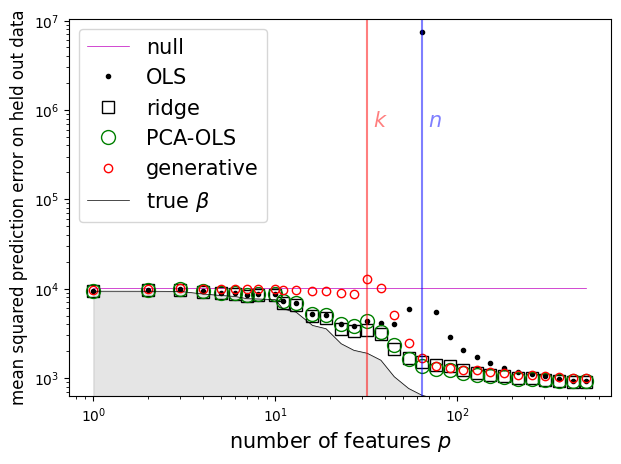

In [21]:
mses_D = np.mean(np.mean(np.mean(dys_D ** 2, axis=-1), axis=-1), axis=-1)  #1 - taking squares and collapse y dim ; 2 - mean squares over test pts; 3 - mean over 16 trials
#att_mses_D = np.mean(np.mean(np.mean(att_dys_D ** 2, axis=-1), axis=-1), axis=-1)
plt.figure(figsize=(7, 5),dpi=100)
plt.subplot(111)
y1 = 0.7 * np.nanmin(mses_D[:, np.array([0,1,2,4,5,6])])
y2 = np.nanmax(mses_D) / 0.7
yt = np.exp(np.log(y1) + 0.95 * np.log(y2 / y1))
plt.fill_between(Ds, mses_D[:, 3], y1 + 0. * mses_D[:, 3], color="k", alpha=0.1)
plt.plot(Ds, mses_D[:, 6], "m-", lw=0.5, label="null") #fixed typo
plt.plot(Ds, mses_D[:, 0], "k.", label="OLS")
plt.plot(Ds, mses_D[:, 5], "ks", mfc="none", ms=8, label="ridge") #fixed typo 
#plt.plot(Ds, mses_D[:, 4], "kx", ms=7, label="xyPCA-OLS")
plt.plot(Ds, mses_D[:, 2], "go", mfc="none", ms=10, label="PCA-OLS")
plt.plot(Ds, mses_D[:, 1], "ro", mfc="none", label="generative")
plt.plot(Ds, mses_D[:, 3], "k-", lw=0.5, label=r"true $\beta$")

#cosmetic
plt.loglog()
plt.axvline(fiducialN, color="b", alpha=0.5)
plt.text(fiducialN, yt/10, r" $n$", color="b", alpha=0.5,size=15)
plt.axvline(K, color="r", alpha=0.5)
plt.text(K, yt/10, r" $k$", color="r", alpha=0.5,size=15)
plt.legend(loc="upper left",fontsize=15)
plt.ylim(y1, y2)
plt.ylabel(r"mean squared prediction error on held out data", size=12)
plt.xlabel(r"number of features $p$",size=15)
#plt.title("varying D at fixed K, N; truncating or extending C")
plt.show()

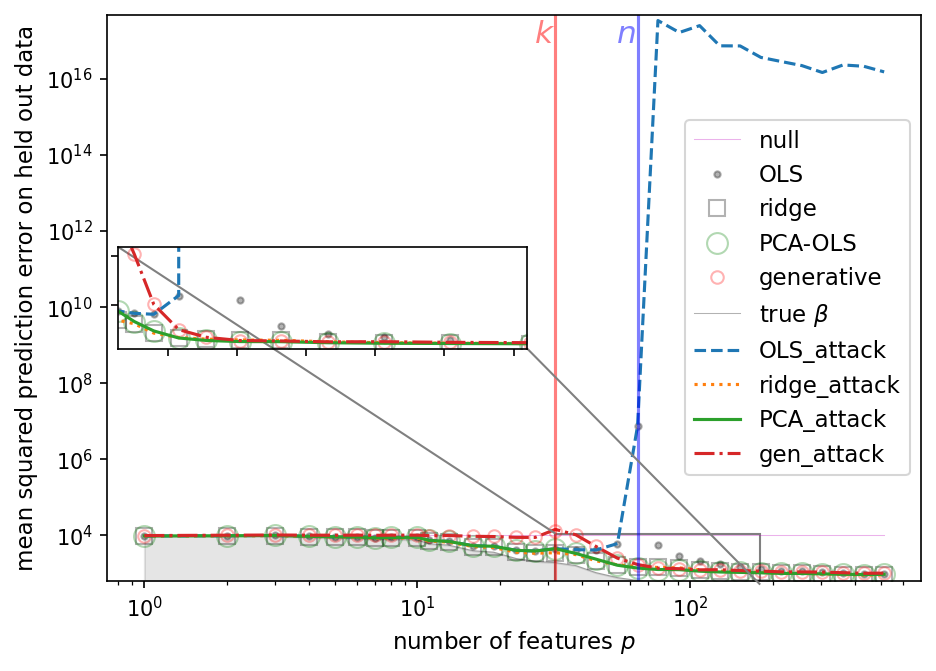

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

att_mses_D = np.mean(np.mean(np.mean(att_dys_D ** 2, axis=-1), axis=-1), axis=-1)
fig, ax = plt.subplots(figsize=(7, 5),dpi=150) 
# label place
y1 = 0.7 * np.nanmin(mses_D[:, np.array([0,1,2,4,5,6])])
y2 = np.nanmax(att_mses_D) / 0.7
yt = np.exp(np.log(y1) + 0.95 * np.log(y2 / y1))
ax.fill_between(Ds, mses_D[:, 3], y1 + 0. * mses_D[:, 3], color="k", alpha=0.1)
ax.plot(Ds, mses_D[:, 6], "m-", lw=0.5, label="null",alpha=0.3) #fixed typo
ax.plot(Ds, mses_D[:, 0], "k.", label="OLS",alpha=0.3)
ax.plot(Ds, mses_D[:, 5], "ks", mfc="none", ms=8, label="ridge",alpha=0.3) #fixed typo 
ax.plot(Ds, mses_D[:, 2], "go", mfc="none", ms=10, label="PCA-OLS",alpha=0.3)
ax.plot(Ds, mses_D[:, 1], "ro", mfc="none", label="generative",alpha=0.3)
ax.plot(Ds, mses_D[:, 3], "k-", lw=0.5, label=r"true $\beta$",alpha=0.3)
#attacks
ax.plot(Ds, att_mses_D[:, 0], "--", label="OLS_attack")
ax.plot(Ds, att_mses_D[:,5],':', label='ridge_attack')
ax.plot(Ds, att_mses_D[:, 2], "-", label="PCA_attack")
ax.plot(Ds, att_mses_D[:,1],'-.', label='gen_attack')
#cosmetic
ax.loglog()
#yt = 0.98*np.max(att_mses_D[:, 0])
ax.axvline(fiducialN, color="b", alpha=0.5)
ax.text(fiducialN, yt, r"$n$ ", color="b", alpha=0.5,size=15,horizontalalignment='right')
ax.axvline(K, color="r", alpha=0.5)
ax.text(K, yt, r"$k$ ", color="r", alpha=0.5,size=15,horizontalalignment='right')
ax.legend(loc='center right', fontsize=11)#,bbox_to_anchor=(1, 0.5))
ax.set_ylabel(r"mean squared prediction error on held out data", size=11)
ax.set_xlabel(r"number of features $p$",size=11)
ax.set_ylim(y1,y2)

#plt.title("varying D at fixed K, N; truncating or extending C")
###ZOOM
x1zoom = K
x2zoom = 180
# select y-range for zoomed region
y1zoom = 5e2
y2zoom = 1.1*1e4
# Make the zoom-in plot:
axins = zoomed_inset_axes(ax, 2, loc='center left') # zoom = 2
axins.plot(Ds, mses_D[:, 0], "k.",alpha=0.3)
axins.plot(Ds, mses_D[:, 5], "ks", mfc="none", ms=8,alpha=0.3) #fixed typo 
axins.plot(Ds, mses_D[:, 2], "go", mfc="none", ms=10,alpha=0.3)
axins.plot(Ds, mses_D[:, 1], "ro", mfc="none", alpha=0.3)
axins.plot(Ds,att_mses_D[:, 0], "--")
axins.plot(Ds, att_mses_D[:,5],':')
axins.plot(Ds,att_mses_D[:, 2], "-")
axins.plot(Ds, att_mses_D[:,1],'-.')
axins.set_xlim(x1zoom, x2zoom)
axins.set_ylim(y1zoom, y2zoom)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()